In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/DTLD_Labels_v2.0.zip" -d "/content/data"
!mv "/content/data/v2.0" "/content/data/DTLD_labels_v2.0"
!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/calibration.zip" -d "/content"
!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/Bremen.zip" -d "/content/data"
!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/Bochum.zip" -d "/content/data"
#!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/Berlin.zip" -d "/content/data"
!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/Frankfurt.zip" -d "/content/data"
!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/Duesseldorf.zip" -d "/content/data"
#!unzip "/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign/DTLD/Essen.zip" -d "/content/data"


Streaming output truncated to the last 5000 lines.
  inflating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-46-17/DE_BBBR667_2015-04-22_17-46-17-962174_k0.tiff  
  inflating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-46-17/DE_BBBR667_2015-04-22_17-46-18-225718_k0.tiff  
  inflating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-46-17/DE_BBBR667_2015-04-22_17-46-21-358821_k0.tiff  
  inflating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-46-17/DE_BBBR667_2015-04-22_17-46-21-624365_nativeV2.tiff  
  inflating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-46-17/DE_BBBR667_2015-04-22_17-46-21-892325_nativeV2.tiff  
  inflating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-46-17/DE_BBBR667_2015-04-22_17-46-19-558604_k0.tiff  
   creating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-29-56/
  inflating: /content/data/Duesseldorf/Duesseldorf5/2015-04-22_17-29-56/DE_BBBR667_2015-04-22_17-29-59-500127_k0.tiff  
  inflating: /content/da

Reference: https://github.com/julimueller/dtld_parsing

In [3]:
import yaml
import numpy as np

class IntrinsicCalibration:
    """
    Intrinsic calibration
    Attributes:
        fx(float):  Focal length in x
        fy(float):  Focal length y
        cx(float):  principal point x
        cy(float):  principal point y
        intrinsic_matrix: Intrinsic camera matrix (opencv format)
    """

    def __init__(self):
        self.fx = 0.0
        self.fy = 0.0
        self.cx = 0.0
        self.cy = 0.0
        self.intrinsic_matrix = []

    def load_matrix(self, matrix):
        """
        Method loading intrinsic camera calibration params from
        matrix
        Args:
            matrix: Intrinsic camera matrix
        """
        self.fx = matrix[0][0]
        self.fy = matrix[1][1]
        self.cx = matrix[0][2]
        self.cy = matrix[1][2]
        self.intrinsic_matrix = matrix



def load_calibration_matrix(path):
  """
  Loads calibration matrix from .yml file.
  Args:
    path: path to yml-matrix
  Returns:
    matrix
  """
  skip_lines = 2
  with open(path) as infile:
    for i in range(skip_lines):
      infile.readline()
    data = yaml.load(infile,  Loader=yaml.FullLoader)
    matrix = np.reshape(data["data"], (data["rows"], data["cols"]))
  return matrix


def load_intrinsic_matrix(path: str):
  """
  This method loads the intrinsic matrix from path
  Args:
    path(str): Path to intrinsic matrix (yml)
  Returns:
    np.array: Intrinsic matrix
  """
  intrinsic_matrix = IntrinsicCalibration()
  matrix = load_calibration_matrix(path)
  intrinsic_matrix.load_matrix(matrix)
  return intrinsic_matrix

In [4]:
import os
import json
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

# class labels for traffic light divided into Light Pictogram and Light state
#   Circle      Arrow Left   Arrow Right     Arrow Str         Tram            Bicycle               Ped
# 0, 1, 2, 3, 4 | 5, 6, 7, 8, 9 | 10, 11, 12, 13, 14 | 15, 16, 17, 18, 19 | 20, 21, 22, 23, 24 | 25, 26, 27, 28, 29|  30, 31, 32, 33, 34
# if the traffic light is occluded and unknown ignore the label.
light_state_dic = {
    "relevant": 0,
    "not relevant": 1,
    "ped" : 2
}

# load intrinsic matrix
intrinsic_matrix = load_intrinsic_matrix('/content/calibration/intrinsic_left.yml')


class TrafficLightObject:
  def __init__(self, object_dic, size_threshold):
    self.x = object_dic['x']
    self.y = object_dic['y']
    self.width = object_dic['w']
    self.height = object_dic['h']
    self.unique_id = object_dic['unique_id']
    self.track_id = object_dic['track_id']
    self.attributes = object_dic['attributes']

    area = self.width * self.height
    if (self.attributes['pictogram'] == "tram" or self.attributes['pictogram'] == "bicycle" or self.attributes["pictogram"] == "pedestrain") and area > size_threshold and self.attributes['relevance'] == "relevant":
      self.text = "Ped"
      self.label = 2
    elif self.attributes['relevance'] != "relevant" and area > size_threshold:
      self.label = 1
      self.text = "not relevant"
    elif self.attributes['relevance'] == "relevant" and area > size_threshold:
      self.label = 0
      self.text = "relevant"
    else:
      self.label = None
  
  def color_from_attributes(self):
    # Second last digit indicates state/color
    if self.label == 0:
      # blue
      return (0, 0, 255)
    elif self.label == 1:
      # Light blue
      return (0, 255, 255)
    elif self.label == 2:
      return (0, 165, 255)
    else:
      # white
      return (255, 255, 255)


class Dataset:
  def __init__(self, jsonFile, size_threshold, generate_validation=False):
    pathJson = os.path.join("/content/data/DTLD_labels_v2.0/", jsonFile)

    # open file
    with open(pathJson, 'r') as file:
      JsonFile = json.load(file)
    
    # get list of images
    listOfImages = JsonFile['images']

    # collect image paths and labels
    self.images = []
    self.labels = []
    self.disparities = []
    for i, image in enumerate(listOfImages):
      trafficLabelCollection = []
      if os.path.exists(os.path.join('/content/data', image['image_path'])):
        for j, label in enumerate(image['labels']):
          trafficLabel = TrafficLightObject(label, size_threshold)
          if trafficLabel.label is not None: trafficLabelCollection.append(trafficLabel)
        self.images.append(os.path.join('/content/data', image['image_path']))
        self.disparities.append(os.path.join('/content/data', image['disparity_image_path']))
        self.labels.append(trafficLabelCollection)
    
    # validation set
    if generate_validation:
      self.images_valid = []
      self.labels_valid = []
      for i in range(len(self.labels)):
        if i % 10 == 0 and len(self.images_valid) < 400:
          image = self.images.pop(i)
          label = self.labels.pop(i)
          self.images_valid.append(image)
          self.labels_valid.append(label)
  
  def __len__(self):
    return len(self.images)
  
  def get_image(self, idx):
    if os.path.isfile(self.images[idx]):
      # Load image form file path, do debayering shift
      img = cv2.imread(self.images[idx], cv2.IMREAD_UNCHANGED)
      img = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2BGR)
      # Images are saved in 12 bit raw -> shift 4 bits
      img = np.right_shift(img, 4)
      img = img.astype(np.uint8)
      return img
    else:
      print("Image: {} not found. Please check image file paths".format(self.images[idx]))
      return False

  def get_validation_image(self, idx):
    if os.path.isfile(self.images_valid[idx]):
      # Load image form file path, do debayering shift
      img = cv2.imread(self.images_valid[idx], cv2.IMREAD_UNCHANGED)
      img = cv2.cvtColor(img, cv2.COLOR_BAYER_GB2BGR)
      # Images are saved in 12 bit raw -> shift 4 bits
      img = np.right_shift(img, 4)
      img = img.astype(np.uint8)
      return img
    else:
      print("Image: {} not found. Please check image file paths".format(self.images[idx]))
      return False

  def get_labeled_image(self, idx):
    img = self.get_image(idx)
    if img is not False:
      for label in self.labels[idx]:
        print(label.label)
        print(label.text)
        cv2.rectangle(
            img,
            (label.x, label.y),
            (label.x + label.width, label.y + label.height),
            label.color_from_attributes(),
            2
        )
        cv2.putText(
            img,
            label.text,
            (label.x, label.y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.9,
            label.color_from_attributes(),
            2
          )
    return img

  def get_disparity_image(self, idx):
    # quantization
    scale = 1.0 / 16.0
    # load raw image
    if os.path.isfile(self.disparities[idx]):
      img = cv2.imread(self.disparities[idx], cv2.IMREAD_UNCHANGED)
    else:
      print("Disparity Image {} not found. Please check image file paths!".format(self.disparities[idx]))
      return None

    # do the magic
    img[img == 255] = 0
    img &= 0x0FFF
    # convert to float
    img= img.astype(np.float32)
    # scale
    img = np.multiply(img, scale, out=img, casting="unsafe")
    return img


  def visualize_disparity_image(self, idx):
    # get disparity image
    img = self.get_disparity_image(idx)
    # rescale to full dynamic
    max = np.max(img)
    min = np.min(img)
    img = img * float((255.0 / float((max - min))))
    img = np.uint8(img)
    # colorize to 3 channels
    img = cv2.applyColorMap(img, cv2.COLORMAP_JET)
    return img

In [7]:
trainDataset = Dataset("DTLD_train.json", 50)
idx = 2500
img = trainDataset.get_labeled_image(idx)
print(len(trainDataset))
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
idx = 150
img = trainDataset.get_labeled_image(idx)
print(len(trainDataset))
cv2_imshow(img)

Output hidden; open in https://colab.research.google.com to view.

# YOLO Dataset

In this section I build YOLO dataset from the DTLD dataset.

YOLO Labeling Format:
- One annotation text file per image.
- Each test file contains one bounding-box (BBox) annotation for each of the objects in the image.
- The annotations are normalized to the image size, and lie within the range of 0 to 1.
- Represented in the format: `<object-class><X_center><Y_center><Box_Width><Box_Height>`

Data Directories Structure:
- To comply with Ultralytics directories structure, the data is provided at the following structure.


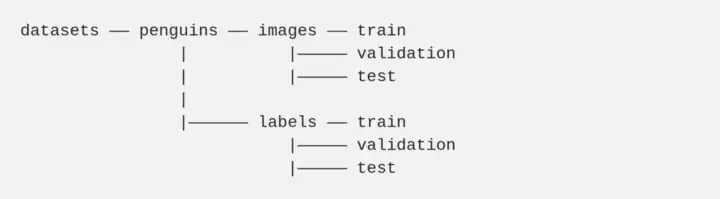

In [5]:
from logging import raiseExceptions
import copy, time
from pathlib import Path

class GenerateYOLO:
  def __call__(self, training, testing):
    self.trainDataset = training
    self.testDataset = testing
    self.__create_data_directories()
    print("Generating Training Labels and Images")
    self.__generate_training_labels_and_images()
    print("Generating Testing Labels and Images")
    self.__generate_testing_labels_and_images()
    print("Generating Validation Labels and Images")
    self.__generate_validation_labels_and_images()
    print("done")


  def __create_data_directories(self):
    Path(f"/content/yolo_dataset/traffic_light/images/train").mkdir(parents=True, exist_ok=True)
    Path(f"/content/yolo_dataset/traffic_light/images/valid").mkdir(parents=True, exist_ok=True)
    Path(f"/content/yolo_dataset/traffic_light/images/test").mkdir(parents=True, exist_ok=True)
    Path(f"/content/yolo_dataset/traffic_light/labels/train").mkdir(parents=True, exist_ok=True)
    Path(f"/content/yolo_dataset/traffic_light/labels/valid").mkdir(parents=True, exist_ok=True)
    Path(f"/content/yolo_dataset/traffic_light/labels/test").mkdir(parents=True, exist_ok=True)

  def __generate_training_labels_and_images(self):
    for i in range(len(self.trainDataset.labels)):
      # grab data
      image = self.trainDataset.get_image(i)
      directory = self.trainDataset.images[i]
      labels = self.trainDataset.labels[i]  
      filename = os.path.basename(directory)
      filename = filename.replace(".tiff", "")
      filename1 = filename + "_part1.txt"
      filename2 = filename + "_part2.txt"

      H, W, _ = image.shape
      leftImage = image[:, :W//2, :]
      rightImage = image[:, W//2:, :]

      # buffer for txt file
      print_buffer_left = []
      print_buffer_right = []
      for label in labels:
        x = label.x
        y = label.y
        w = label.width
        h = label.height
        #print("***********")
        #print("x: " + str(x))
        #print("x + w:" + str(x + w))
        if x < W // 2 and x + w < W //2 :
          #print("Left")
          x_center = float((x + w) / 2.0)
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x < W // 2 and x + w > W // 2:
          #print("Middle")
          w_left = (W//2) - x
          w_right = w - w_left
          x1, y1 = x, y
          x2, y2 = 0, y

          #print("width left: " + str(w_left))
          #print("width right: " + str(w_right))
          #print("(x1, y1): " + str((x1, y1)))
          #print("(x2, y2): " + str((x2, y2)))

          # left
          x_center_left = float((x1 + w_left) / 2.0)
          y_center_left = float((y1 + h) / 2.0)
          norm_x_center_left = float(x_center_left / (W//2))
          norm_y_center_left = float(y_center_left / H)
          norm_w_left = float(w_left / (W//2))
          norm_h_left = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center_left, norm_y_center_left, norm_w_left, norm_h_left))
          # right
          x_center_right = float((x1 + w_right) / 2.0)
          y_center_right = float((y1 + h) / 2.0)
          norm_x_center_right = float(x_center_right / (W//2))
          norm_y_center_right = float(y_center_right / H)
          norm_w_right = float(w_right / (W//2))
          norm_h_right = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center_right, norm_y_center_right, norm_w_right, norm_h_right))
        elif x > W // 2:
          x_center = float(((x - W//2) + w) / 2.0)
          if x_center < 0:
            print("very bad")
            raise
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x + w == W//2:
          x_center = float((x + w) / 2.0)
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x == W //2:
          x_center = float(((x - W//2) + w) / 2.0)
          if x_center < 0:
            print("very bad")
            raise
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        else:
          print("Boundary Box is undefined.")
          print("x: " + str(x))
          print("x + w:" + str(x + w))
          raise
        
      # Name of the file which we have to save
      save_file_name1 = os.path.join("/content/yolo_dataset/traffic_light/labels/train", filename1)
      save_file_name2 = os.path.join("/content/yolo_dataset/traffic_light/labels/train", filename2)

      # Save the annotation to disk
      print("\n".join(print_buffer_left), file=open(save_file_name1, "w"))
      print("\n".join(print_buffer_right), file=open(save_file_name2, "w"))

      # copy image into directory and change to .tiff to .png
      cv2.imwrite(os.path.join("/content/yolo_dataset/traffic_light/images/train", filename1.replace(".txt", ".png")), leftImage)
      cv2.imwrite(os.path.join("/content/yolo_dataset/traffic_light/images/train", filename2.replace(".txt", ".png")), rightImage)

      # display
      print("Completed: {} of {}".format(i, len(self.trainDataset.labels)))



  def __generate_testing_labels_and_images(self):
    for i in range(len(self.testDataset.labels)):
      # grab data
      image = self.testDataset.get_image(i)
      directory = self.testDataset.images[i]
      labels = self.testDataset.labels[i]  
      filename = os.path.basename(directory)
      filename = filename.replace(".tiff", "")
      filename1 = filename + "_part1.txt"
      filename2 = filename + "_part2.txt"

      H, W, _ = image.shape
      leftImage = image[:, :W//2, :]
      rightImage = image[:, W//2:, :]

      # buffer for txt file
      print_buffer_left = []
      print_buffer_right = []
      for label in labels:
        x = label.x
        y = label.y
        w = label.width
        h = label.height
        #print("***********")
        #print("x: " + str(x))
        #print("x + w:" + str(x + w))
        if x < W // 2 and x + w < W //2 :
          #print("Left")
          x_center = float((x + w) / 2.0)
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x < W // 2 and x + w > W // 2:
          #print("Middle")
          w_left = (W//2) - x
          w_right = w - w_left
          x1, y1 = x, y
          x2, y2 = 0, y

          #print("width left: " + str(w_left))
          #print("width right: " + str(w_right))
          #print("(x1, y1): " + str((x1, y1)))
          #print("(x2, y2): " + str((x2, y2)))

          # left
          x_center_left = float((x1 + w_left) / 2.0)
          y_center_left = float((y1 + h) / 2.0)
          norm_x_center_left = float(x_center_left / (W//2))
          norm_y_center_left = float(y_center_left / H)
          norm_w_left = float(w_left / (W//2))
          norm_h_left = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center_left, norm_y_center_left, norm_w_left, norm_h_left))
          # right
          x_center_right = float((x1 + w_right) / 2.0)
          y_center_right = float((y1 + h) / 2.0)
          norm_x_center_right = float(x_center_right / (W//2))
          norm_y_center_right = float(y_center_right / H)
          norm_w_right = float(w_right / (W//2))
          norm_h_right = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center_right, norm_y_center_right, norm_w_right, norm_h_right))
        elif x > W // 2:
          x_center = float(((x - W//2) + w) / 2.0)
          if x_center < 0:
            print("very bad")
            raise
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x + w == W//2:
          x_center = float((x + w) / 2.0)
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x == W //2:
          x_center = float(((x - W//2) + w) / 2.0)
          if x_center < 0:
            print("very bad")
            raise
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        else:
          print("Boundary Box is undefined.")
          raise
        
      # Name of the file which we have to save
      save_file_name1 = os.path.join("/content/yolo_dataset/traffic_light/labels/test", filename1)
      save_file_name2 = os.path.join("/content/yolo_dataset/traffic_light/labels/test", filename2)

      # Save the annotation to disk
      print("\n".join(print_buffer_left), file=open(save_file_name1, "w"))
      print("\n".join(print_buffer_right), file=open(save_file_name2, "w"))

      # copy image into directory and change to .tiff to .png
      cv2.imwrite(os.path.join("/content/yolo_dataset/traffic_light/images/test", filename1.replace(".txt", ".png")), leftImage)
      cv2.imwrite(os.path.join("/content/yolo_dataset/traffic_light/images/test", filename2.replace(".txt", ".png")), rightImage)

      # display
      print("Completed: {} of {}".format(i, len(self.testDataset.labels)))


  def __generate_validation_labels_and_images(self):
    for i in range(len(self.testDataset.labels_valid)):
      # grab data
      image = self.testDataset.get_validation_image(i)
      directory = self.testDataset.images_valid[i]
      labels = self.testDataset.labels_valid[i]  
      filename = os.path.basename(directory)
      filename = filename.replace(".tiff", "")
      filename1 = filename + "_part1.txt"
      filename2 = filename + "_part2.txt"

      H, W, _ = image.shape
      leftImage = image[:, :W//2, :]
      rightImage = image[:, W//2:, :]

      # buffer for txt file
      print_buffer_left = []
      print_buffer_right = []
      for label in labels:
        x = label.x
        y = label.y
        w = label.width
        h = label.height
        #print("***********")
        #print("x: " + str(x))
        #print("x + w:" + str(x + w))
        if x < W // 2 and x + w < W //2 :
          #print("Left")
          x_center = float((x + w) / 2.0)
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x < W // 2 and x + w > W // 2:
          #print("Middle")
          w_left = (W//2) - x
          w_right = w - w_left
          x1, y1 = x, y
          x2, y2 = 0, y

          #print("width left: " + str(w_left))
          #print("width right: " + str(w_right))
          #print("(x1, y1): " + str((x1, y1)))
          #print("(x2, y2): " + str((x2, y2)))

          # left
          x_center_left = float((x1 + w_left) / 2.0)
          y_center_left = float((y1 + h) / 2.0)
          norm_x_center_left = float(x_center_left / (W//2))
          norm_y_center_left = float(y_center_left / H)
          norm_w_left = float(w_left / (W//2))
          norm_h_left = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center_left, norm_y_center_left, norm_w_left, norm_h_left))
          # right
          x_center_right = float((x1 + w_right) / 2.0)
          y_center_right = float((y1 + h) / 2.0)
          norm_x_center_right = float(x_center_right / (W//2))
          norm_y_center_right = float(y_center_right / H)
          norm_w_right = float(w_right / (W//2))
          norm_h_right = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center_right, norm_y_center_right, norm_w_right, norm_h_right))
        elif x > W // 2:
          x_center = float(((x - W//2) + w) / 2.0)
          if x_center < 0:
            print("very bad")
            raise
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x + w == W//2:
          x_center = float((x + w) / 2.0)
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_left.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        elif x == W //2:
          x_center = float(((x - W//2) + w) / 2.0)
          if x_center < 0:
            print("very bad")
            raise
          y_center = float((y + h) / 2.0)
          norm_x_center = float(x_center / (W//2))
          norm_y_center = float(y_center / H)
          norm_w = float(w / (W//2))
          norm_h = float(h / H)
          print_buffer_right.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(label.label, norm_x_center, norm_y_center, norm_w, norm_h))
        else:
          print("Boundary Box is undefined.")
          raise
        
      # Name of the file which we have to save
      save_file_name1 = os.path.join("/content/yolo_dataset/traffic_light/labels/valid", filename1)
      save_file_name2 = os.path.join("/content/yolo_dataset/traffic_light/labels/valid", filename2)

      # Save the annotation to disk
      print("\n".join(print_buffer_left), file=open(save_file_name1, "w"))
      print("\n".join(print_buffer_right), file=open(save_file_name2, "w"))

      # copy image into directory and change to .tiff to .png
      cv2.imwrite(os.path.join("/content/yolo_dataset/traffic_light/images/valid", filename1.replace(".txt", ".png")), leftImage)
      cv2.imwrite(os.path.join("/content/yolo_dataset/traffic_light/images/valid", filename2.replace(".txt", ".png")), rightImage)

      # display
      print("Completed: {} of {}".format(i, len(self.testDataset.labels_valid)))

Create yolo dataset on drive

In [8]:
trainDataset = Dataset("DTLD_train.json", 100)
testDataset = Dataset("DTLD_test.json", 100, generate_validation=True)
print("Size of training: {}".format(len(trainDataset)*2))
print("Size of validation: {}".format(len(testDataset.labels_valid)*2))
print("Size of testing: {}".format(len(testDataset)*2))

IndexError: ignored

In [ ]:
Yolo = GenerateYOLO()
Yolo(trainDataset, testDataset)


Generating Training Labels and Images
Completed: 0 of 12249
Completed: 1 of 12249
Completed: 2 of 12249
Completed: 3 of 12249
Completed: 4 of 12249
Completed: 5 of 12249
Completed: 6 of 12249
Completed: 7 of 12249
Completed: 8 of 12249
Completed: 9 of 12249
Completed: 10 of 12249
Completed: 11 of 12249
Completed: 12 of 12249
Completed: 13 of 12249
Completed: 14 of 12249
Completed: 15 of 12249
Completed: 16 of 12249
Completed: 17 of 12249
Completed: 18 of 12249
Completed: 19 of 12249
Completed: 20 of 12249
Completed: 21 of 12249
Completed: 22 of 12249
Completed: 23 of 12249
Completed: 24 of 12249
Completed: 25 of 12249
Completed: 26 of 12249
Completed: 27 of 12249
Completed: 28 of 12249
Completed: 29 of 12249
Completed: 30 of 12249
Completed: 31 of 12249
Completed: 32 of 12249
Completed: 33 of 12249
Completed: 34 of 12249
Completed: 35 of 12249
Completed: 36 of 12249
Completed: 37 of 12249
Completed: 38 of 12249
Completed: 39 of 12249
Completed: 40 of 12249
Completed: 41 of 12249
Comple

KeyboardInterrupt: ignored

In [ ]:
image_path = '/content/yolo_dataset/traffic_light/images/train'
label_path = '/content/yolo_dataset/traffic_light/labels/train'


list_labels = os.listdir(label_path)
for i in range(len(list_labels)):
  a_file = open(os.path.join(label_path, list_labels[i]))
  list_of_lists = []
  for line in a_file:
    stripped_line = line.strip()
    line_list = stripped_line.split()
    list_of_lists.append(line_list)
  a_file.close()

  labels = os.path.join(image_path, list_labels[i].replace(".txt", ".png"))
  print(labels)
  image = cv2.imread(labels)
  H, W, _ = image.shape
  print(list_of_lists)
  for x in list_of_lists:
    
    label_class, x_center, y_center, width, height = float(x[0]), float(x[1]), float(x[2]), float(x[3]), float(x[4])
    w = int(width * W)
    h = int(height * H)
    x = int((2.0 * (x_center * W)) - w)
    y = int((2.0 * (y_center * H)) - h)
    if label_class == 0:
      image = cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    elif label_class == 1:
      image = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 0, 255), 2)
    else:
      image = cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
  cv2_imshow(image)
  if i > 50:
    break

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!rm -r '/content/data'
!zip -r '/content/yolo_dataset.zip' '/content/yolo_dataset'

Streaming output truncated to the last 5000 lines.
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-22_11-35-10-363673_k0_part2.png (deflated 1%)
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-24_17-46-50-881144_k0_part2.png (deflated 2%)
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-22_17-12-27-443736_k0_part2.png (deflated 1%)
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-22_15-35-30-814174_k0_part2.png (deflated 1%)
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-17_14-10-42-841548_k0_part2.png (deflated 1%)
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-22_17-03-50-577638_k0_part2.png (deflated 1%)
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-17_12-18-11-232786_k0_part2.png (deflated 1%)
updating: content/yolo_dataset/traffic_light/images/train/DE_BBBR667_2015-04-22_17-11-17

In [ ]:
!ls -sh

total 40G
4.0K calibration  4.0K sample_data  4.0K yolo_dataset   40G yolo_dataset.zip


In [ ]:
!cp '/content/yolo_dataset.zip' '/content/drive/MyDrive/Colab Code/RobotPerception/Project/TrafficSign'

In [ ]:
drive.flush_and_unmount()